<a href="https://colab.research.google.com/github/pixelwizard2/Project.AI--ColorQuest---AI-s-Journey-in-Reviving-WWII-Imagery/blob/main/ColorQuest_code_(%ED%95%9C%EA%B5%AD%EC%96%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Google Drive 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. 데이터 파일 불러오기(확인용)

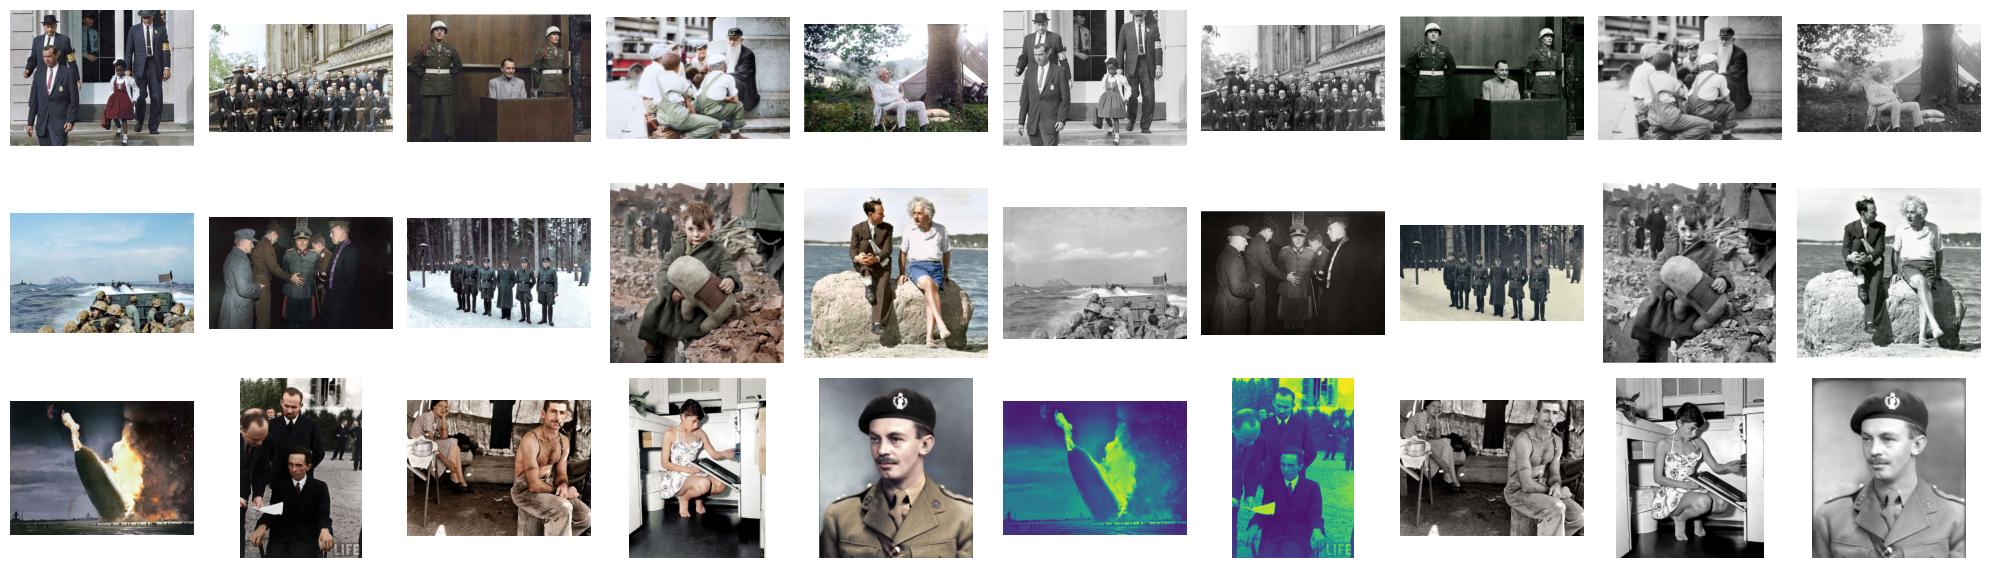

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 두 폴더 경로
folder_path1 = '/content/drive/My Drive/image_dataset(1)/color_images'
folder_path2 = '/content/drive/My Drive/image_dataset(1)/gray_images'

# 이미지 파일 목록
image_files1 = [os.path.join(folder_path1, f) for f in os.listdir(folder_path1) if os.path.isfile(os.path.join(folder_path1, f))]
image_files2 = [os.path.join(folder_path2, f) for f in os.listdir(folder_path2) if os.path.isfile(os.path.join(folder_path2, f))]

# 이미지 표시를 위한 준비
fig, axes = plt.subplots(3, 10, figsize=(20, 6))  # 3행 10열의 서브플롯 생성

# 왼쪽에 폴더1의 이미지들을 벌집 모양으로 배열
for i, file in enumerate(image_files1):
    img = mpimg.imread(file)
    ax = axes[i // 5, i % 5]  # 3행 5열에 이미지를 배치
    ax.imshow(img)
    ax.axis('off')

# 오른쪽에 폴더2의 이미지들을 벌집 모양으로 배열
for i, file in enumerate(image_files2):
    img = mpimg.imread(file)
    ax = axes[i // 5, i % 5 + 5]  # 3행 5열에 이미지를 배치 (5를 더하여 오른쪽에 배치)
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

3. 이미지 불러오기 및 전처리

In [27]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input, concatenate, Dropout, BatchNormalization

# 데이터 불러오기 및 전처리
def load_images(folder_path, color_mode, image_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        if color_mode == 'color':
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = np.expand_dims(img, axis=-1)
        img = cv2.resize(img, image_size)
        img = img / 255.0
        images.append(img)
    return np.stack(images)

# 이미지 폴더 경로
folder_path1 = '/content/drive/My Drive/image_dataset(1)/color_images'
folder_path2 = '/content/drive/My Drive/image_dataset(1)/gray_images'

color_images = load_images(folder_path1, color_mode='color')
gray_images = load_images(folder_path2, color_mode='gray')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.1, random_state=42)

# 모델 생성 시 입력 형태 설정
input_shape = (256, 256, 1)  # 흑백 이미지의 경우 (256, 256, 1)

4. 딥러닝 모델 설계(4가지) 및 구축

In [28]:
# 다양한 딥러닝 모델 설계 및 구축
def build_simple_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model


def build_deep_cnn(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))     # 업샘플링을 한 번만 적용합니다.
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return model




def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, x)
    return autoencoder


def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = Dropout(0.5)(conv3)

    # Decoding path
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = Dropout(0.5)(conv4)

    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = Dropout(0.25)(conv5)

    # Output layer
    conv6 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(conv5)

    unet = Model(inputs=[inputs], outputs=[conv6])
    return unet

5. 모델 생성 및 컴파일


In [29]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 모델 이름과 해당하는 함수를 사전에 매핑
model_builders = {
    'simple_cnn': build_simple_cnn,
    'deep_cnn': build_deep_cnn,
    'autoencoder': build_autoencoder,
    'unet': build_unet,
}

# X_train과 X_test에 채널 차원 추가
X_train = X_train.reshape(X_train.shape[0], 256, 256, 1)
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

# 입력 형태를 정의
input_shape = X_train.shape[1:]

# 모든 모델을 생성하고 컴파일
models = {}
for name, builder in model_builders.items():
    print(f"Building and compiling the {name} model...")
    model = builder(input_shape)
    model.compile(optimizer='adam', loss='mean_squared_error')
    models[name] = model
    model.summary()  # 모델 요약 출력

Building and compiling the simple_cnn model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 conv2d_90 (Conv2D)          (None, 256, 256, 3)       867       
                                                                 
Total params: 1187 (4.64 KB)
Trainable params: 1187 (4.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Building and compiling the deep_cnn model...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_91 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 12

6. 모델 학습 및 성능 평가

Training simple_cnn...
Epoch 1/10
11/11 [==============================] - 2s 102ms/step - loss: 0.0826 - val_loss: 0.1001
Epoch 2/10
11/11 [==============================] - 1s 94ms/step - loss: 0.0766 - val_loss: 0.0956
Epoch 3/10
11/11 [==============================] - 1s 94ms/step - loss: 0.0732 - val_loss: 0.0894
Epoch 4/10
11/11 [==============================] - 1s 95ms/step - loss: 0.0687 - val_loss: 0.0820
Epoch 5/10
11/11 [==============================] - 1s 95ms/step - loss: 0.0634 - val_loss: 0.0743
Epoch 6/10
11/11 [==============================] - 1s 97ms/step - loss: 0.0579 - val_loss: 0.0643
Epoch 7/10
11/11 [==============================] - 1s 96ms/step - loss: 0.0517 - val_loss: 0.0544
Epoch 8/10
11/11 [==============================] - 1s 93ms/step - loss: 0.0466 - val_loss: 0.0467
Epoch 9/10
11/11 [==============================] - 1s 94ms/step - loss: 0.0425 - val_loss: 0.0359
Epoch 10/10
11/11 [==============================] - 1s 135ms/step - loss: 0.0346 - v

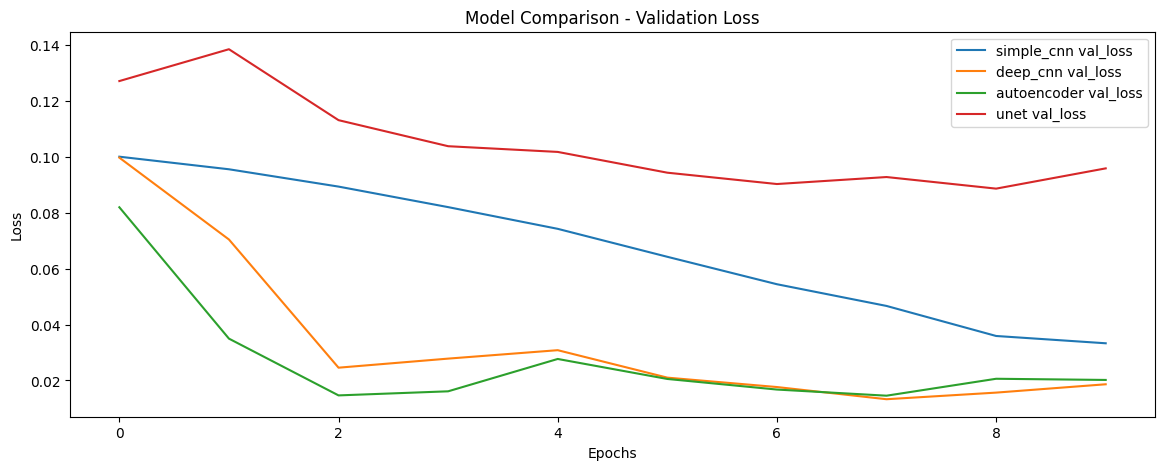

In [30]:
# 모델 학습 및 성능 평가
history_dict = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.1)
    history_dict[name] = history
    model.save(f"{name}_model.h5")

# 모델별 성능 비교를 위한 손실 그래프
plt.figure(figsize=(14, 5))
for name, history in history_dict.items():
    val_loss = history.history['val_loss']
    plt.plot(val_loss, label=f'{name} val_loss')

plt.title('Model Comparison - Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7. 모델 다운로드

In [31]:
from google.colab import files

# 모든 모델을 순회하면서 각각을 다운로드합니다.
for name in models.keys():
    file_name = f"{name}_model.h5"
    # 구글 드라이브에서 다운로드 링크를 생성합니다.
    files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# 저장된 모델 파일을 구글 드라이브로 이동시킵니다.
for name in models.keys():
    file_name = f"{name}_model.h5"
    destination_path = f"/content/drive/My Drive/{file_name}"
    !cp {file_name} {destination_path}  # 파일을 구글 드라이브로 복사합니다.

cp: target 'Drive/simple_cnn_model.h5' is not a directory
cp: target 'Drive/deep_cnn_model.h5' is not a directory
cp: target 'Drive/autoencoder_model.h5' is not a directory
cp: target 'Drive/unet_model.h5' is not a directory


8. 모델 업로드

In [37]:
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
import numpy as np
import cv2

# 불러올 모델들의 목록입니다.
model_names = ['simple_cnn', 'deep_cnn', 'autoencoder', 'unet']

# 각 모델을 불러옵니다.
loaded_models = {}
for name in model_names:
    file_path = f"/content/drive/MyDrive/{name}_model.h5"
    loaded_models[name] = load_model(file_path)

for name, model in loaded_models.items():   # 모델이 정상적으로 불러와졌는지 확인하는 코드
    print(f"{name} model is loaded.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
simple_cnn model is loaded.
deep_cnn model is loaded.
autoencoder model is loaded.
unet model is loaded.


9. 모델 구현(흑백사진 변환)

In [36]:
# 테스트 이미지에 대한 컬러화 예측 및 결과 저장
test_image_paths = ['/content/drive/My Drive/test_photo_before1.jpg',
                    '/content/drive/My Drive/test_photo_before2.jpg']

for path in test_image_paths:
    test_image = load_images([path], color_mode='gray', image_size=(256, 256))
    test_image = np.expand_dims(test_image, axis=0)  # Add batch dimension

    for name, model in loaded_models.items():
        predicted = model.predict(test_image)
        predicted = np.squeeze(predicted) * 255.0  # Remove batch dimension and rescale
        output_path = path.replace('before', f'after_{name}')
        cv2.imwrite(output_path, cv2.cvtColor(predicted.astype(np.uint8), cv2.COLOR_RGB2BGR))
        print(f"Output saved to {output_path}")

print("All models have been trained and evaluated.")

TypeError: listdir: path should be string, bytes, os.PathLike, integer or None, not list